In [1]:
import cv2, os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scivision.io import load_dataset

In [2]:
# Set VM data path and read labels file

dataPath = '/scratch/data/images/'
df_ind = pd.read_csv('/scratch/data/index.csv')
df_ind.head()

,index,filename,label1,label2,label3
0,1,Pia1.2016-10-04.1801+N292_hc.tif,zooplankton,noncopepod,annelida_polychaeta
1,2,Pia1.2016-10-05.1229+N28_hc.tif,zooplankton,noncopepod,annelida_polychaeta
2,3,Pia1.2016-10-06.2118+N136_hc.tif,zooplankton,noncopepod,annelida_polychaeta
3,4,Pia1.2017-03-21.1136+N01644266_hc.tif,zooplankton,noncopepod,annelida_polychaeta
4,5,Pia1.2017-03-21.1136+N01646706_hc.tif,zooplankton,noncopepod,annelida_polychaeta


In [3]:
# check for image overlaps in two classes

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [4]:
def preprocess(im, size, blur, gray=True):
    im = cv2.GaussianBlur(im, (blur, blur),0)
    if gray:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    else:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im,(size, size))
    return im

# View Images

Pia1.2016-08-02.1631+N38_hc._fx.tif
(40, 40)


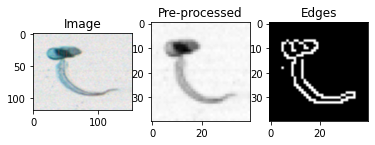

Pia1.2016-08-02.1631+N38_hc._fxy.tif
(40, 40)


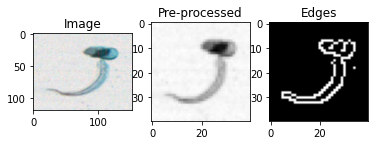

Pia1.2016-08-02.1631+N38_hc._fy.tif
(40, 40)


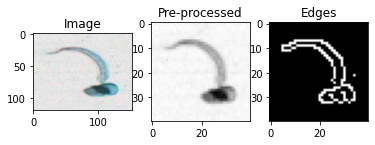

In [5]:
for i in sorted(os.listdir(dataPath))[:3]:
    im_full = cv2.imread(dataPath + i)
    print(i)
#     print("avg/std rgb: ", np.mean(im_full, axis=(0,1)), np.std(im_full, axis=(0,1)))
    
    im = preprocess(im_full, 40, 5)
    print(im.shape)
    edges = cv2.Canny(im, 50, 50)
    
    plt.subplot(131), plt.title("Image"),plt.imshow(im_full)
    plt.subplot(132), plt.title("Pre-processed"), plt.imshow(im, cmap="gray")
    plt.subplot(133), plt.title("Edges"), plt.imshow(edges, cmap="gray")
#     plt.savefig(str(i) + "preprocess.png")
    plt.show()

# Label 2 - Plankton

In [6]:
df_ind['label2'].value_counts()

detritus      40000
copepod       10346
noncopepod     8445
Name: label2, dtype: int64

In [7]:
cop_im_list = df_ind[df_ind['label2']=='copepod']['filename'].tolist()
noncop_im_list = df_ind[df_ind['label2']=='noncopepod']['filename'].tolist()

print(len(cop_im_list), len(noncop_im_list))
print(intersection(cop_im_list, noncop_im_list))

10346 8445
['Pia1.2017-10-26.1849+N00011891_hc.tif', 'Pia1.2017-10-03.1726+N00294605_hc.tif', 'Pia1.2017-10-03.1726+N00358839_hc.tif']


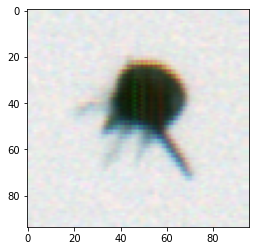

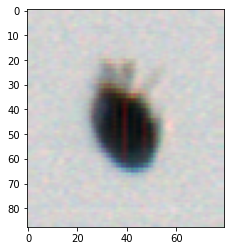

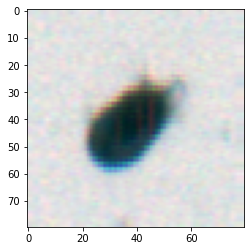

In [14]:
overlap_list = ['Pia1.2017-10-26.1849+N00011891_hc.tif', 'Pia1.2017-10-03.1726+N00294605_hc.tif', 'Pia1.2017-10-03.1726+N00358839_hc.tif']

for i in overlap_list:
    
    im = cv2.imread(dataPath + i)
    plt.imshow(im)
    plt.show()

In [8]:
for i in intersection(cop_im_list, noncop_im_list):
    cop_im_list.remove(i)
    noncop_im_list.remove(i)

In [9]:
print(len(cop_im_list), len(noncop_im_list))

10343 8442


In [10]:
savePath = '/shared/jenniferding/plankton/cop/'
n = 500

for i in sorted(cop_im_list)[:n]:
    im = cv2.imread(dataPath + i)
#     print(dataPath + i)
    im = preprocess(im, 128, 3, gray=False)
    cv2.imwrite(savePath+i, im)

In [12]:
print(len(os.listdir('/shared/jenniferding/plankton/cop/')))

500


In [11]:
savePath = '/shared/jenniferding/plankton/noncop/'
n = 500

for i in sorted(noncop_im_list)[:n]:
    im = cv2.imread(dataPath + i)
#     print(dataPath + i)
    im = preprocess(im, 128, 3, gray=False)
    cv2.imwrite(savePath+i, im)

In [13]:
print(len(os.listdir('/shared/jenniferding/plankton/noncop/')))

500


# Label 1 - All Images

In [ ]:
# View distribution of class 1 labels (detritus vs. zooplankton)

df_ind['label1'].value_counts()

In [ ]:
detritus_im_list = df_ind[df_ind['label1']=='detritus']['filename'].tolist()
plankton_im_list = df_ind[df_ind['label1']=='zooplankton']['filename'].tolist()

print(len(detritus_im_list), len(plankton_im_list))
print(intersection(detritus_im_list, plankton_im_list))

In [ ]:
savePath = '/shared/images_cnn/detritus/'

for i in sorted(detritus_im_list)[:20000]:
    im = cv2.imread(dataPath + i)
#     print(dataPath + i)
    im = preprocess(im, 40, 5)
    cv2.imwrite(savePath+i, im)

In [ ]:
print(len(os.listdir('/shared/images_cnn/detritus/')))

In [ ]:
dataPath = '/shared/images_cnn/detritus/'

for i in sorted(os.listdir(dataPath))[:5]:

    im = cv2.imread(dataPath + i)
    print(i)
    plt.imshow(im, cmap="gray")
    plt.show()

In [ ]:
savePath = '/shared/images_cnn/plankton/'

for i in sorted(plankton_im_list):
    im = cv2.imread(dataPath + i)
#     print(dataPath + i)
    im = preprocess(im, 40, 5)
    cv2.imwrite(savePath+i, im)

In [ ]:
print(len(os.listdir('/shared/images_cnn/plankton/')))

In [ ]:
dataPath = '/shared/images_cnn/plankton/'

for i in sorted(os.listdir(dataPath))[:10]:
    im = cv2.imread(dataPath + i)
    print(i)
    plt.imshow(im, cmap="gray")
    plt.show()

# Load Data - Scivision
- Deduplicate and view labels & example image

In [ ]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels = cat.labels().read()

labels_dedup = xr.Dataset.from_dataframe(
    labels
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

In [ ]:
one_image = ds_labelled.sel(concat_dim=1)
plt.imshow(one_image['raster'].compute().values[:,:,:])
plt.title(one_image.filename.compute().values)

In [ ]:
# get image width and length into columns
ds_labelled = ds_labelled.assign(
    image_width = ds_labelled['EXIF Image ImageWidth'].to_pandas().apply(lambda x: x.values[0]),
    image_length = ds_labelled['EXIF Image ImageLength'].to_pandas().apply(lambda x: x.values[0])
)